In [30]:
# Libraries
from typing import Optional
import matplotlib.pyplot as plt
import mplcursors
import numpy as np
from matplotlib.backends.backend_qtagg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib.ticker import MaxNLocator
from PyQt6.QtWidgets import QMainWindow, QVBoxLayout, QWidget
from enum import Enum


# Internal
def convert_multipliers_to_coordinate(
    multipliers: list[float], last_y_coordinates: Optional[list[int]] = None
) -> list[int]:
    """
    convert multipliers to Y coordinate
    :param multipliers: list of multipliers
    :param last_y_coordinates: list of last Y coordinates
        (only if you want to continue the list)
    :return: list of Y coordinates
    """
    y = last_y_coordinates or []
    for multiplier in multipliers:
        value = 1 if multiplier >= 2 else -1
        last_value = 0 if len(y) == 0 else y[-1]
        value_ = last_value + value
        y.append(value_)
    return y


def calculate_slope_linear_regression(
    y: list[float], len_window: Optional[int] = -11
) -> tuple[float, float]:
    """
    calculate the slope of the linear regression
    using to know if a graph is going up or down
    :param y: is the list of values to calculate the slope
    :param len_window: is the length of the window to calculate the slope
    :return: tuple the slope and the intercept
    """
    if not y:
        return -1, 0
    len_window = abs(len_window) * -1
    if len(y) > len_window:
        y = y[len_window:]
    x = np.arange(len(y))
    # Calculate the slope of the linear regression
    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    return float(slope), intercept

    
def determine_bullish_game(*, multipliers: list[float], min_value_to_bullish_game: float, len_window: int) -> bool:
    y_coordinates = convert_multipliers_to_coordinate(
        multipliers
    )
    slope, _ = calculate_slope_linear_regression(
        y_coordinates, len_window
    )
    return slope >= min_value_to_bullish_game



class BullishGameValues(dict[str, any], Enum):
    LOW = {"value": 0.26, "index": 0}
    MEDIUM = {"value": 0.5, "index": 1}
    HIGH = {"value": 0.7, "index": 2}

    def get_value(self) -> float:
        return self.value["value"]

    def get_index(self) -> int:
        return self.value["index"]

    @staticmethod
    def get_by_index(index: int) -> any:
        for value in BullishGameValues:
            if value.value["index"] == index:
                return value
        return None

    @staticmethod
    def get_by_value(value: float) -> any:
        for val in BullishGameValues:
            if val.value["value"] == value:
                return val
        return None


class BarMultiplier(QVBoxLayout):
    def __init__(
        self,
        multipliers: list[float],
    ):
        super().__init__()
        # self.max_multipliers = max_multipliers
        self._multipliers = []
        self.bar_heights = []
        self.bar_colors = []
        self.bar_width = 0.9
        fig, self.ax = plt.subplots()
        plt.margins(x=0, y=0.03, tight=False)
        #fig.set_figwidth(parent.geometry().width() / 100)
        #fig.set_figheight(parent.geometry().height() / 100)
        fig.tight_layout()
        fig.set_facecolor("#232323")
        self.ax.set_facecolor("#000000")
        self.ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
        self.ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
        self.canvas = FigureCanvas(fig)
        # self.canvas_layout.addWidget(self.canvas)
        self.addWidget(self.canvas)
        # Add a bar chart to the plot
        self.bar_heights = []
        self.bar_colors = []
        self.x_data = []
        self.add_multipliers(multipliers)
        x0 = 0.01
        y0 = 0.01
        x1 = 0.99
        y1 = 0.99
        self.ax.set_position((x0, y0, x1, y1))
        # ax.legend()

    @property
    def max_multipliers(self):
        return 40

    def draw(self):
        self.canvas.draw()

    def __get_bar_height(self, multipliers: list[float]) -> list[int]:
        bar_height = self.bar_heights or []
        if bar_height and len(bar_height) >= self.max_multipliers:
            bar_height.pop(0)
        bar_height = convert_multipliers_to_coordinate(
            multipliers, bar_height
        )
        """for multiplier in multipliers:
            value = 1 if multiplier >= 2 else -1
            last_value = 0 if len(bar_height) == 0 else bar_height[-1]
            value_ = last_value + value
            bar_height.append(value_)"""
        return bar_height

    def __get_bar_color(self, multipliers: list[float]):
        # use https://matplotlib.org/stable/gallery/color/named_colors.html
        bar_colors = self.bar_colors or []
        if bar_colors and len(bar_colors) >= self.max_multipliers:
            bar_colors.pop(0)
        for multiplier in multipliers:
            if multiplier < 2:
                bar_colors.append("deepskyblue")
            elif 2 <= multiplier < 10:
                bar_colors.append("darkviolet")
            else:
                bar_colors.append("crimson")
        return bar_colors

    @staticmethod
    def _find_support_resistance(
        *, prices: list[int], window=3
    ) -> tuple[list[tuple[int, int]], list[tuple[int, int]]]:
        """
        Find support and resistance levels
        support, resistance = self._find_support_resistance(
            prices=self.bar_heights
        )
        for s in support:
            plt.axhline(y=s[1], color='m', linestyle='--',
            linewidth=0.8, label="Soporte" if s == support[0] else None)
        for r in resistance:
            plt.axhline(y=r[1], color='c', linestyle='--', linewidth=0.8,
                        label="Resistencia" if r == resistance[0] else None)
        :param prices:
        :param window:
        :return:
        """
        support = []
        resistance = []
        for index in range(window, len(prices) - window):
            price_range = prices[index - window : index + window + 1]  # NOQA
            max_price = max(price_range)
            min_price = min(price_range)
            if prices[index] == max_price:
                resistance.append((index, max_price))
            elif prices[index] == min_price:
                support.append((index, min_price))
        return support, resistance

    def add_multipliers(self, multipliers: list[float]):
        if not multipliers:
            return
        self._multipliers += multipliers
        if len(multipliers) > self.max_multipliers:
            multipliers = multipliers[-self.max_multipliers :]  # noqa
        if len(self._multipliers) > self.max_multipliers:
            self._multipliers = self._multipliers[
                -self.max_multipliers :  # noqa
            ]
        self.bar_heights = self.__get_bar_height(multipliers)
        self.bar_colors = self.__get_bar_color(multipliers)
        self.x_data = [i + 1 for i in range(len(self.bar_heights))]
        # ax = self.canvas.figure.axes[0]
        self.ax.clear()
        self.ax.set_xlim(-0.1, len(self.bar_heights) + 0.5)
        self.ax.set_xticks([])
        for i, (cat, val) in enumerate(zip(self.x_data, self.bar_heights)):
            bar_patch = self.round_bar(i, 0, 1, val, 0.5, self.bar_colors[i])
            self.ax.add_patch(bar_patch)
        x_line = np.arange(len(self.x_data)) + 0.5
        self.ax.plot(
            x_line, self.bar_heights, color="w", marker="o", markersize=1
        )
        cursor = mplcursors.cursor(
            hover=mplcursors.HoverMode.Transient,
            annotation_kwargs=dict(
                bbox=dict(
                    boxstyle="round,pad=.5",
                    fc="white",
                    alpha=1,
                    ec="w",
                ),
                arrowprops=dict(
                    arrowstyle="->",
                    connectionstyle="angle3",
                    shrinkB=0,
                    ec="w",
                    fc="w",
                ),
            ),
        )

        @cursor.connect("add")
        def on_add(sel):
            ann = sel.annotation
            x, y = ann.xy
            x_ = f"{x:.0f}"
            x = int(x_)
            if x >= len(self._multipliers):
                cursor.remove_selection(sel)
                return
            _multiplier = self._multipliers[x]
            if _multiplier < 2:
                fc = "deepskyblue"
            elif 2 <= _multiplier < 10:
                fc = "darkviolet"
            else:
                fc = "crimson"
            sel.annotation.get_bbox_patch().set(fc=fc)
            ann.set_text(f"{_multiplier}")

        self.ax.grid(axis="y", color="gray", linestyle="dashed", linewidth=0.4)
        self.ax.set_yticklabels([])
        # for label in self.ax.get_yticklabels():
        #    label.set_color("white")
        self.draw()

    @staticmethod
    def round_bar(x, y, width, height, radius=0.4, color="skyblue"):
        left, right = x, x + width
        bottom, top = y, y + height
        path_ = [
            (left, bottom),
            (right, bottom),
            (right, bottom),
            (right, bottom),
            (right, top),
            (right, top),
            (right, top),
            (left, top),
            (left, top),
            (left, top),
            (left, bottom),
        ]
        if height > 0:
            path_ = [
                (left, bottom),
                (right, bottom),
                (right, bottom),
                (right, bottom),
                (right, top - radius),
                (right, top),
                (right - radius, top),
                (left + radius, top),
                (left, top),
                (left, top - radius),
                (left, bottom),
            ]
        elif height < 0:
            path_ = [
                (left, bottom),
                (right, bottom),
                (right, bottom),
                (right, bottom),
                (right, top + radius),
                (right, top),
                (right - radius, top),
                (left + radius, top),
                (left, top),
                (left, top + radius),
                (left, bottom),
            ]
        path = Path(
            path_,
            [  # NOQA
                Path.MOVETO,
                Path.LINETO,
                Path.CURVE3,
                Path.CURVE3,
                Path.LINETO,
                Path.CURVE3,
                Path.CURVE3,
                Path.LINETO,
                Path.CURVE3,
                Path.CURVE3,
                Path.LINETO,
            ],
        )
        return PathPatch(path, facecolor=color, edgecolor="k")


Es alcista: True




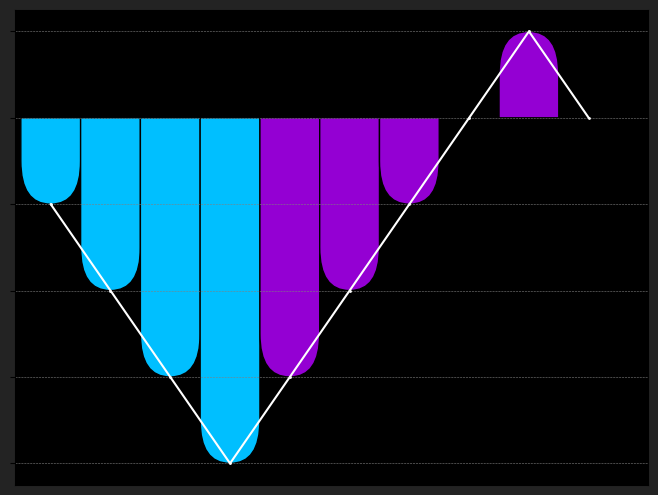

In [96]:
multipliers = [-2,-1,0,1,2,3,4,5,6,1]
is_bullish_game = determine_bullish_game(
    multipliers=multipliers,
    min_value_to_bullish_game=BullishGameValues.LOW.get_value(),
    len_window=5
)

print(f"Es alcista: {is_bullish_game}\n\n")
bar = BarMultiplier(multipliers=multipliers)